# Setting

## Import Libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.framework import convert_to_constants
from tensorflow.keras.preprocessing import image

#  model 에 따라 변경
from tensorflow.keras.applications import resnet50 as keras_model

## Download Data

In [4]:
!mkdir data

!wget  -O data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

mkdir: cannot create directory ‘data’: File exists
--2021-11-09 16:40:12--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 99.86.144.99, 99.86.144.87, 99.86.144.75, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|99.86.144.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘data/img0.JPG’

data/img0.JPG       100%[===================>]  23.55K  --.-KB/s    in 0s      

2021-11-09 16:40:12 (57.6 MB/s) - ‘data/img0.JPG’ saved [24112/24112]

--2021-11-09 16:40:12--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 23.185.0.4, 2620:12a:8001::4, 2620:12a:8000::4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|23.185.0.4|:443... connected.
HTTP request sent, awaiting res

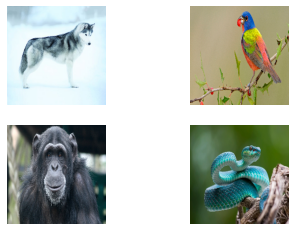

In [5]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');

## variable

예제 실행에서 사용하는 변수 정의

In [12]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
    img_path = f'data/img{i%4}.JPG'
    img = image.load_img(img_path, target_size=(224, 224))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras_model.preprocess_input(x)
    batched_input[i, :] = x
    
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


## Define Function

예제 실행에서 사용하는 함수 정의

- ~_model: frozen graph 대상
- ~_tftrt: saved model 대상

In [2]:
# test for frzen_graph
def predict_model(model):
    """
    Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = 'data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras_model.preprocess_input(x)
    x = tf.constant(x)
    
    frozen_graph_predictions = model(x)
    
    preds = frozen_graph_predictions[0].numpy()
    print('{} - Predicted: {}'.format(img_path, keras_model.decode_predictions(preds, top=3)[0]))

    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(keras_model.decode_predictions(preds, top=3)[0][0][1])

In [3]:
# test for frzen_graph

def benchmark_model(model):    
    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []
    
    for i in range(N_warmup_run):
        preds = model(batched_input)

    for i in range(N_run):
        start_time = time.time()
        preds = model(batched_input)
        end_time = time.time()

        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [4]:
def predict_tftrt(saved_model_loaded):
    """
    Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = 'data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras_model.preprocess_input(x)
    x = tf.constant(x)
    
    infer = saved_model_loaded.signatures['serving_default']
    
    preds =  infer(x)['predictions'].numpy() 
    print('{} - Predicted: {}'.format(img_path, keras_model.decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(keras_model.decode_predictions(preds, top=3)[0][0][1])

In [5]:
def benchmark_tftrt(saved_model_loaded):
    infer = saved_model_loaded.signatures['serving_default']
    
    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []
    
    for i in range(N_warmup_run):
        preds = infer(batched_input)

    for i in range(N_run):
        start_time = time.time()
        preds = infer(batched_input)
        end_time = time.time()

        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [6]:
def get_dummy_images(batch_size = 32, img_shape = [224, 224, 3]):
    img=tf.random.uniform(shape=[batch_size] + img_shape, dtype=tf.float32)
    print("Generated input random images with shape (N, H, W, C) =", img.shape)
    return img

In [7]:
# save loaded model as frozen pb file

def save_frozen_graph(saved_model_loaded, output_path):
    graph_func = saved_model_loaded.signatures['serving_default']
    
    full_model = tf.function(lambda x: graph_func(x))
    full_model = full_model.get_concrete_function(
            tf.TensorSpec(graph_func.inputs[0].shape, graph_func.inputs[0].dtype))

    frozen_func = convert_to_constants.convert_variables_to_constants_v2(full_model)
    frozen_func.graph.as_graph_def()
    
    # Save frozen graph from frozen ConcreteFunction to hard drive
    tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=output_path,
                  name="frozen_graph.pb",
                  as_text=False)

In [8]:
def load_frozen_graph(input_path):
    
    def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
        def _imports_graph_def():
            tf.compat.v1.import_graph_def(graph_def, name="")

        wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
        import_graph = wrapped_import.graph

        if print_graph == True:
            print("-" * 50)
            print("Frozen model layers: ")
            layers = [op.name for op in import_graph.get_operations()]
            for layer in layers:
                print(layer)
            print("-" * 50)

        return wrapped_import.prune(
            tf.nest.map_structure(import_graph.as_graph_element, inputs),
            tf.nest.map_structure(import_graph.as_graph_element, outputs))

    # Load frozen graph using TensorFlow 1.x functions
    with tf.io.gfile.GFile(f'./{input_path}/frozen_graph.pb', 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        loaded = graph_def.ParseFromString(f.read())

    # Wrap frozen graph to ConcreteFunctions
    frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                    inputs=["x:0"],
                                    outputs=["Identity:0"],
                                    print_graph=False)
    
    return frozen_func

# Test

Int 8 converted model load

In [17]:
# model load and check loading time

start_time = time.time()
saved_model_loaded = tf.keras.models.load_model('resnet50_saved_model_TFTRT_INT8_build')
end_time = time.time()

load_term = (end_time - start_time)/60
print(f'{load_term} min')

16.166752938429514 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5962649), ('n02109961', 'Eskimo_dog', 0.37307543), ('n02110063', 'malamute', 0.025809996)]


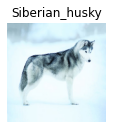

In [18]:
predict_tftrt(saved_model_loaded)

In [19]:
benchmark_tftrt(saved_model_loaded)

Step 0: 29.2ms
Step 50: 28.0ms
Step 100: 28.0ms
Step 150: 28.0ms
Step 200: 28.0ms
Step 250: 28.0ms
Step 300: 28.0ms
Step 350: 28.0ms
Step 400: 28.0ms
Step 450: 28.0ms
Step 500: 28.0ms
Step 550: 28.1ms
Step 600: 28.0ms
Step 650: 28.0ms
Step 700: 27.9ms
Step 750: 28.0ms
Step 800: 27.9ms
Step 850: 27.9ms
Step 900: 27.9ms
Step 950: 28.0ms
Throughput: 286 images/s


## test with frozen graph

In [9]:
# model load and check loading time

start_time = time.time()
frozen_func = load_frozen_graph('[frozen]resnet50_saved_model_TFTRT_INT8_build')
end_time = time.time()

load_term = (end_time - start_time)/60
print(f'{load_term} min')

13.847417942682902 min


data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5962649), ('n02109961', 'Eskimo_dog', 0.37307543), ('n02110063', 'malamute', 0.025809996)]


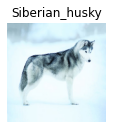

In [10]:
predict_model(frozen_func)

In [13]:
benchmark_model(frozen_func)

Step 0: 26.3ms
Step 50: 25.9ms
Step 100: 26.0ms
Step 150: 25.9ms
Step 200: 25.9ms
Step 250: 25.9ms
Step 300: 26.0ms
Step 350: 25.9ms
Step 400: 26.0ms
Step 450: 25.9ms
Step 500: 25.9ms
Step 550: 26.0ms
Step 600: 26.0ms
Step 650: 25.9ms
Step 700: 25.9ms
Step 750: 25.9ms
Step 800: 25.9ms
Step 850: 25.9ms
Step 900: 25.9ms
Step 950: 25.9ms
Throughput: 309 images/s
